# Fine-tuning Whisper (Custom)

- Reference 대로 하니 상당히 번거롭다. 직접 설계해보자.

# 0. Hyperparameters

In [1]:
class Config:
    batch_size = 8
    learning_rate = 0.00005
    warmup_steps = 2000
    num_epochs = 3
    eval_steps = 1000

# 1. Preprocessing

## 1.1. Load Pre-trained Model

In [2]:
import torch
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor, WhisperForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "openai/whisper-base"
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)
tokenizer = WhisperTokenizer.from_pretrained(model_name, language="Korean", task="transcribe")
processor = WhisperProcessor.from_pretrained(model_name, language="Korean", task="transcribe")
whisper_model = WhisperForConditionalGeneration.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

C:\Users\Poco\anaconda3\envs\hty\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Poco\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

In [3]:
whisper_model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          

## 1.2. Prepare Dataset

- **주의!!** 아래 작업을 **이전에 한번 수행했던 적이 있으면** <span style="color:red">**여기!**</span> 표시가 나오는 구간까지 생략하세요.

### 1.2.1. Load Dataset

- 다음 작업은 **상당한 시간이 소요**됩니다. (**30분 이상**)

In [85]:
from datasets import load_dataset
dataset = load_dataset("audiofolder", data_dir="D:/01 서울시립대학교/03 5학년 2학기/01 소프트웨어응용/Dataset")

Resolving data files:   0%|          | 0/66514 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/12102 [00:00<?, ?it/s]

Computing checksums:  92%|#########2| 61519/66515 [00:05<00:00, 12301.87it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [86]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'label'],
        num_rows: 66514
    })
    test: Dataset({
        features: ['audio', 'text', 'label'],
        num_rows: 12102
    })
})

In [87]:
if 'test' in dataset:
    dataset.pop('test') # test dataset은 train와 val dataset에 포함시키지 않겠다.

In [88]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'label'],
        num_rows: 66514
    })
})

### 1.2.2. Resampling

In [89]:
# 먼저 원래의 데이터셋을 확인해보자.
dataset['train'][0] # sampling_rate이 44100으로 설정되어있다.

{'audio': {'path': 'D:/01 서울시립대학교/03 5학년 2학기/01 소프트웨어응용/Dataset/train/audio/1.강제추행(성범죄)/1.강제추행(성범죄)_105088_label.wav',
  'array': array([0.00012207, 0.00021362, 0.00012207, ..., 0.00027466, 0.00039673,
         0.00039673]),
  'sampling_rate': 44100},
 'text': '만지지 마세요',
 'label': 1}

In [90]:
from datasets import Audio

# 오디오 샘플을 로드할 때 resampling(sampling rate 조정)을 수행한다.
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [92]:
# 변환된 데이터셋을 확인해보자.
dataset["train"][0] # sampling_rate이 16000으로 변환되었다.

{'audio': {'path': 'D:/01 서울시립대학교/03 5학년 2학기/01 소프트웨어응용/Dataset/train/audio/1.강제추행(성범죄)/1.강제추행(성범죄)_105088_label.wav',
  'array': array([1.05414874e-04, 1.22038946e-04, 2.06689336e-04, ...,
         4.76218520e-05, 3.10715928e-04, 0.00000000e+00]),
  'sampling_rate': 16000},
 'text': '만지지 마세요',
 'label': 1}

### 1.2.3. feature extract and tokenize

In [93]:
# 데이터셋을 학습에 알맞게 준비해보자.
def prepare_dataset(batch):
    # 데이터셋(batch)에서 오디오 정보를 추출한다. (Resampling 포함: 48kHz -> 16kHz)
    audio = batch["audio"]

    # 원본을 찾기 위한 path를 남겨둔다.
    batch["path"] = audio["path"]

    # Log-melspectrogram feature를 batch 데이터 정보에 추가한다.
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # text를 토큰화한 id들을 batch 데이터 정보에 추가한다.
    if batch["text"] == None: # text가 None이면 ''으로 변경한다.
        batch["labels"] = tokenizer('').input_ids
    else:
        batch["labels"] = tokenizer(batch["text"]).input_ids

    # 추후에 classification에 이용할 label 데이터를 추가한다.
    batch["class"] = batch["label"]

    # audio의 length를 데이터로 추가한다.
    batch["length"] = len(audio["array"])/audio["sampling_rate"]
    return batch

- 바로 아래 코드는 <u>**실행 시간이 <span style="color:red">상당히 오래</span> 걸리니**</u> 실행에 주의할 것! (**60분 이상**)
- **C 드라이브 용량**이 **200GB 이상** 남아있는지도 확인하라!!

In [95]:
prepared_dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=None)

Map:   0%|          | 0/66514 [00:00<?, ? examples/s]

In [96]:
prepared_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'input_features', 'labels', 'class', 'length'],
        num_rows: 66514
    })
})

In [98]:
prepared_dataset['train'][0]

{'path': 'D:/01 서울시립대학교/03 5학년 2학기/01 소프트웨어응용/Dataset/train/audio/1.강제추행(성범죄)/1.강제추행(성범죄)_105088_label.wav',
 'input_features': [[-0.4640601873397827,
   -0.5179513692855835,
   -0.49511265754699707,
   -0.5088584423065186,
   -0.4817490577697754,
   -0.5432233810424805,
   -0.5350234508514404,
   -0.347042441368103,
   -0.3561742305755615,
   -0.4466738700866699,
   -0.4628317356109619,
   -0.40486109256744385,
   -0.46050143241882324,
   -0.5432233810424805,
   -0.5432233810424805,
   -0.5432233810424805,
   -0.5270447731018066,
   -0.5432233810424805,
   -0.5432233810424805,
   -0.5327873229980469,
   -0.5090265274047852,
   -0.48429715633392334,
   -0.40395426750183105,
   -0.5364214181900024,
   -0.5432233810424805,
   -0.5432233810424805,
   -0.5432233810424805,
   -0.500435471534729,
   -0.5432233810424805,
   -0.3937746286392212,
   -0.4232442378997803,
   -0.3746054172515869,
   -0.36798763275146484,
   -0.48491668701171875,
   -0.48159098625183105,
   -0.3913978338241577,
   

- 다음 코드는 **상당한 시간이 소요**됩니다. (**10분 이상**)

In [99]:
# 앞으로 전처리 과정을 생략하기 위해 prepared_dataset을 local에 저장해둔다.
prepared_dataset.save_to_disk("./prepared_dataset")

Saving the dataset (0/128 shards):   0%|          | 0/66514 [00:00<?, ? examples/s]

# 1.3. Here!

- (<span style="color:red">**여기!**</span>) 위 작업을 이전에 한번 수행했던 적이 있으면 아래 작업만으로 빠르게 데이터셋을 불러올 수 있습니다.

In [100]:
from datasets import load_dataset
prepared_dataset = load_dataset("./prepared_dataset")

Resolving data files:   0%|          | 0/129 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [101]:
# 제대로 불러왔는지 테스트해보자.
prepared_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'input_features', 'labels', 'class', 'length'],
        num_rows: 66514
    })
})

In [102]:
# train dataset과 test dataset으로 분리한다.
split_dataset = prepared_dataset['train'].train_test_split(test_size=0.01, seed=42)

In [103]:
# 여기에서 출력되는 test는 validation dataset임을 명심하라!
split_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'input_features', 'labels', 'class', 'length'],
        num_rows: 65848
    })
    test: Dataset({
        features: ['path', 'input_features', 'labels', 'class', 'length'],
        num_rows: 666
    })
})

### 1.3.1. Dataset

In [104]:
split_dataset.set_format("torch")

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

### 1.3.2. Data Collate Function

In [9]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 인풋 데이터와 라벨 데이터의 길이가 다르며, 따라서 서로 다른 패딩 방법이 적용되어야 한다. 그러므로 두 데이터를 분리해야 한다.
        # 먼저 오디오 인풋 데이터를 간단히 토치 텐서로 반환하는 작업을 수행한다.
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Tokenize된 레이블 시퀀스를 가져온다.
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # 레이블 시퀀스에 대해 최대 길이만큼 패딩 작업을 실시한다.
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 패딩 토큰을 -100로 치환하여 loss 계산 과정에서 무시되도록 한다.
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        
        # 이전 토크나이즈 과정에서 bos 토큰이 추가되었다면 bos 토큰을 잘라낸다.
        # 해당 토큰은 이후 언제든 추가할 수 있다.
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["dec_input_ids"] = labels
        batch["labels"] = torch.cat((labels[:, 1:], torch.full(labels[:, 1:2].shape, -100)), dim=1)

        class_list = [feature["class"] for feature in features] # class label은 0부터 시작해야 함. 그러나 Dataset에는 1부터 시작함.
        # 앞으로 0을 None Class로 정의.
        classes = torch.stack(class_list)
        batch["classes"] = classes
        
        length_list = [feature["length"] for feature in features]
        lengths = torch.stack(length_list)
        batch["lengths"] = lengths
        return batch

In [10]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

### 1.3.3. DataLoader

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=Config.batch_size, collate_fn=data_collator)

In [12]:
sample = next(iter(train_dataloader))
sample['input_features'].shape

torch.Size([8, 80, 3000])

In [13]:
sample['labels'].shape

torch.Size([8, 38])

In [14]:
sample['lengths']

tensor([32.9030,  2.7300,  5.0668,  2.8749,  3.1100, 15.9999,  4.0900,  3.1950])

# 2. Model Architecture

In [15]:
import torch
import torch.nn as nn

whisper_model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="korean", task="transcribe")
class CustomModel(nn.Module):
    def __init__(self, whisper_model=whisper_model):
        super().__init__()
        self.encoder = whisper_model.model.encoder
        self.decoder = whisper_model.model.decoder
        self.proj_out = whisper_model.proj_out

        # ViT(Vision Transformer)의 MLP Head에서 아이디어를 가져온다.
        self.MLPHead = nn.Sequential(
            nn.Linear(in_features=512, out_features=3072, bias=True),
            nn.Linear(in_features=3072, out_features=20, bias=True) # None Class 포함
        )

    def forward(self, inputs):
        input_features = inputs['input_features'].to(device)
        audio_features = self.encoder(input_features)

        dec_input_ids = inputs['dec_input_ids'].to(device)
        dec_input_ids[dec_input_ids == -100] = tokenizer.pad_token_id # Critical Point!!! -100이 아닌 pad로 입력해야 한다.
        out = self.decoder(input_ids=dec_input_ids, encoder_hidden_states=audio_features[0])
        out = self.proj_out(out[0])

        logits = self.MLPHead(audio_features.last_hidden_state) # classification

        return (out, logits)

model = CustomModel()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

CustomModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
     

# 3. Training

## 3.1. Optimizer and Scheduler

In [16]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=Config.learning_rate)

In [17]:
num_training_steps = Config.num_epochs * len(train_dataloader)
print("num_training_steps:", num_training_steps)

num_training_steps: 24693


In [18]:
from transformers import get_scheduler

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=Config.warmup_steps, num_training_steps=num_training_steps
)

In [19]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

In [20]:
# 동기화
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 3.2. CER metric

In [21]:
import evaluate

metric_cer = evaluate.load("cer")

pred_str_list = []
label_str_list = []
def compute_metrics(pred, label):
    pred_ids = pred
    label_ids = label

    # replace -100 with the pad_token_id (50257: pad_token_id)
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    new_pred_str = []
    new_label_str = []
    if '' in label_str:
        for pred, label in zip(pred_str, label_str):
            if label != '':
                new_pred_str.append(pred)
                new_label_str.append(label)
    else:
        new_pred_str = pred_str
        new_label_str = label_str
    pred_str_list.append(new_pred_str)
    label_str_list.append(new_label_str)
    if len(new_label_str) == 0:
        return (None, 0)
    cer = 100 * metric_cer.compute(predictions=new_pred_str, references=new_label_str)

    return (None, cer)

## 3.3. Train loop

In [22]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

log_steps = []

train_loss_text_list = []
train_loss_label_list = []
train_loss_total_list = []

val_loss_text_list = []
val_loss_label_list = []
val_loss_total_list = []
val_accuracy_list = []
val_cer_list = []
val_real_accuracy_list = []

steps = 0
for epoch in range(1, Config.num_epochs+1):
    model.train()
    for batch in train_dataloader:
        classes = batch['classes']
        lengths = batch['lengths']
        class_labels = torch.zeros(len(lengths), 1500, dtype=torch.int64)
        for i, (c, l) in enumerate(zip(classes, lengths)):
            n = min(int(lengths[i]*50), 1500)
            class_labels[i][:n] = c
        class_labels = class_labels.to(device)

        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        outputs = model(batch)
        
        loss_text = loss_fn(outputs[0].view(-1, outputs[0].size(-1)), labels.view(-1))
        loss_label = loss_fn(outputs[1].view(-1, 20), class_labels.view(-1))/15
        loss = loss_text + loss_label

        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        steps += 1
        
        if steps % Config.eval_steps == 0:
            model.eval()
            print('Evaluation...')
    
            train_loss_text = loss_text
            train_loss_label = loss_label
            train_loss_total = loss
            
            accuracy_list = []
            predictions_list = []
            labels_list = []
            CER = 0
            val_loss_text = 0
            val_loss_label = 0
            val_loss_total = 0
            num_batches = len(val_dataloader)
            for batch in tqdm(val_dataloader, leave=True):
                classes = batch['classes']
                lengths = batch['lengths']
                class_labels = torch.zeros(len(lengths), 1500, dtype=torch.int64)
                for i, (c, l) in enumerate(zip(classes, lengths)):
                    n = min(int(lengths[i]*50), 1500)
                    class_labels[i][:n] = c
                class_labels = class_labels.to(device)
                
                batch = {k: v.to(device) for k, v in batch.items()}
                labels = batch['labels']
                with torch.no_grad():
                    outputs = model(batch)
            
                _, cer = compute_metrics(torch.argmax(outputs[0], dim=-1), labels)
                CER += cer
    
                loss_text = loss_fn(outputs[0].view(-1, outputs[0].size(-1)), labels.view(-1))
                loss_label = loss_fn(outputs[1].view(-1, 20), class_labels.view(-1))/15
                loss = loss_text + loss_label
    
                val_loss_text += loss_text / num_batches
                val_loss_label += loss_label / num_batches
                val_loss_total += loss / num_batches
            
                logits = outputs[1]
                predictions = torch.argmax(logits, dim=-1)

                mode_list = []
                for i in range(len(predictions)):
                    mode, _ = torch.mode(predictions[i][predictions[i] != 0])
                    mode_list.append(mode)
                predictions_list.extend(mode_list)
                labels_list.extend(list(batch['classes']))
            
                correct = torch.eq(predictions, class_labels)
                accuracy = torch.mean(correct.float())
                accuracy_list.append(float(accuracy))
    
            log_steps.append(steps)
            train_loss_text_list.append(train_loss_text)
            train_loss_label_list.append(train_loss_label)
            train_loss_total_list.append(train_loss_total)
            val_loss_text_list.append(val_loss_text)
            val_loss_label_list.append(val_loss_label)
            val_loss_total_list.append(val_loss_total)
            
            accuracy = sum(accuracy_list)/num_batches
            cer = CER/num_batches
            real_accuracy = sum(x == y for x, y in zip(predictions_list, labels_list))/len(labels_list)

            val_accuracy_list.append(accuracy)
            val_cer_list.append(cer)
            val_real_accuracy_list.append(real_accuracy)
            
            print(f'[Steps: {steps:5d}]')
            print(f'| Training Text Loss: {train_loss_text:.7f} | Training Label Loss: {train_loss_label:.7f} | Training Total Loss: {train_loss_total:.7f} |')
            print(f'| Validation Text Loss: {val_loss_text:.7f} | Validation Label Loss: {val_loss_label:.7f} | Validation Total Loss: {val_loss_total:.7f} |')
            print(f'| Validation Accuracy: {accuracy:.7f} | Validation CER: {cer:.7f} | Validation Real Accuracy: {real_accuracy:.7f} |')
            
            model.train()

    folder_path = 'whisper_save05'
    os.makedirs(folder_path, exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }, os.path.join(folder_path, f'ckpt-{epoch}.pt'))


  0%|          | 0/24693 [00:00<?, ?it/s]

Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  1000]
| Training Text Loss: 0.8147925 | Training Label Loss: 0.0349366 | Training Total Loss: 0.8497292 |
| Validation Text Loss: 0.3447534 | Validation Label Loss: 0.0377206 | Validation Total Loss: 0.3824742 |
| Validation Accuracy: 0.7971557 | Validation CER: 20.9787646 | Validation Real Accuracy: 0.2807808 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  2000]
| Training Text Loss: 1.6329719 | Training Label Loss: 0.0254781 | Training Total Loss: 1.6584500 |
| Validation Text Loss: 1.0247911 | Validation Label Loss: 0.0272520 | Validation Total Loss: 1.0520427 |
| Validation Accuracy: 0.8440159 | Validation CER: 58.4019304 | Validation Real Accuracy: 0.5405406 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  3000]
| Training Text Loss: 0.9402975 | Training Label Loss: 0.0183107 | Training Total Loss: 0.9586082 |
| Validation Text Loss: 0.4069769 | Validation Label Loss: 0.0228520 | Validation Total Loss: 0.4298289 |
| Validation Accuracy: 0.8709633 | Validation CER: 19.5816447 | Validation Real Accuracy: 0.6516517 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  4000]
| Training Text Loss: 0.4986077 | Training Label Loss: 0.0059172 | Training Total Loss: 0.5045249 |
| Validation Text Loss: 1.5447785 | Validation Label Loss: 0.0182943 | Validation Total Loss: 1.5630727 |
| Validation Accuracy: 0.8927173 | Validation CER: 80.7366276 | Validation Real Accuracy: 0.7447448 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  5000]
| Training Text Loss: 0.5300745 | Training Label Loss: 0.0121046 | Training Total Loss: 0.5421790 |
| Validation Text Loss: 1.2799691 | Validation Label Loss: 0.0133914 | Validation Total Loss: 1.2933608 |
| Validation Accuracy: 0.9308284 | Validation CER: 94.6830252 | Validation Real Accuracy: 0.8333334 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  6000]
| Training Text Loss: 0.3969734 | Training Label Loss: 0.0115277 | Training Total Loss: 0.4085011 |
| Validation Text Loss: 0.8998926 | Validation Label Loss: 0.0113074 | Validation Total Loss: 0.9111998 |
| Validation Accuracy: 0.9447867 | Validation CER: 37.3254856 | Validation Real Accuracy: 0.8783784 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  7000]
| Training Text Loss: 0.4429141 | Training Label Loss: 0.0188084 | Training Total Loss: 0.4617226 |
| Validation Text Loss: 1.3372583 | Validation Label Loss: 0.0084790 | Validation Total Loss: 1.3457369 |
| Validation Accuracy: 0.9587500 | Validation CER: 58.0110743 | Validation Real Accuracy: 0.8888889 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  8000]
| Training Text Loss: 0.4852105 | Training Label Loss: 0.0064611 | Training Total Loss: 0.4916716 |
| Validation Text Loss: 1.3187071 | Validation Label Loss: 0.0072132 | Validation Total Loss: 1.3259202 |
| Validation Accuracy: 0.9659484 | Validation CER: 79.8986064 | Validation Real Accuracy: 0.9129130 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps:  9000]
| Training Text Loss: 0.6169490 | Training Label Loss: 0.0029766 | Training Total Loss: 0.6199257 |
| Validation Text Loss: 0.9298524 | Validation Label Loss: 0.0073914 | Validation Total Loss: 0.9372441 |
| Validation Accuracy: 0.9656002 | Validation CER: 37.2000442 | Validation Real Accuracy: 0.9189190 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 10000]
| Training Text Loss: 0.2085318 | Training Label Loss: 0.0046410 | Training Total Loss: 0.2131729 |
| Validation Text Loss: 1.4857445 | Validation Label Loss: 0.0062317 | Validation Total Loss: 1.4919759 |
| Validation Accuracy: 0.9710575 | Validation CER: 87.0300788 | Validation Real Accuracy: 0.9354355 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 11000]
| Training Text Loss: 0.0814235 | Training Label Loss: 0.0047968 | Training Total Loss: 0.0862202 |
| Validation Text Loss: 1.3556712 | Validation Label Loss: 0.0055669 | Validation Total Loss: 1.3612380 |
| Validation Accuracy: 0.9731706 | Validation CER: 97.8013914 | Validation Real Accuracy: 0.9459460 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 12000]
| Training Text Loss: 0.2150155 | Training Label Loss: 0.0033800 | Training Total Loss: 0.2183955 |
| Validation Text Loss: 0.5818927 | Validation Label Loss: 0.0041966 | Validation Total Loss: 0.5860893 |
| Validation Accuracy: 0.9817292 | Validation CER: 25.7365509 | Validation Real Accuracy: 0.9609610 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 13000]
| Training Text Loss: 0.3157430 | Training Label Loss: 0.0051789 | Training Total Loss: 0.3209219 |
| Validation Text Loss: 0.8924441 | Validation Label Loss: 0.0048723 | Validation Total Loss: 0.8973164 |
| Validation Accuracy: 0.9773383 | Validation CER: 59.2104316 | Validation Real Accuracy: 0.9564565 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 14000]
| Training Text Loss: 0.1606276 | Training Label Loss: 0.0011279 | Training Total Loss: 0.1617555 |
| Validation Text Loss: 0.4076778 | Validation Label Loss: 0.0033114 | Validation Total Loss: 0.4109892 |
| Validation Accuracy: 0.9845992 | Validation CER: 24.8336826 | Validation Real Accuracy: 0.9714715 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 15000]
| Training Text Loss: 0.3383220 | Training Label Loss: 0.0028298 | Training Total Loss: 0.3411517 |
| Validation Text Loss: 0.7291763 | Validation Label Loss: 0.0037180 | Validation Total Loss: 0.7328944 |
| Validation Accuracy: 0.9847083 | Validation CER: 41.3463785 | Validation Real Accuracy: 0.9609610 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 16000]
| Training Text Loss: 0.2390518 | Training Label Loss: 0.0008097 | Training Total Loss: 0.2398615 |
| Validation Text Loss: 0.5334630 | Validation Label Loss: 0.0031863 | Validation Total Loss: 0.5366494 |
| Validation Accuracy: 0.9869881 | Validation CER: 23.0484016 | Validation Real Accuracy: 0.9759760 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 17000]
| Training Text Loss: 0.0658259 | Training Label Loss: 0.0004460 | Training Total Loss: 0.0662719 |
| Validation Text Loss: 0.6792021 | Validation Label Loss: 0.0027217 | Validation Total Loss: 0.6819241 |
| Validation Accuracy: 0.9879077 | Validation CER: 34.1910289 | Validation Real Accuracy: 0.9729730 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 18000]
| Training Text Loss: 0.3082834 | Training Label Loss: 0.0015991 | Training Total Loss: 0.3098826 |
| Validation Text Loss: 0.8937725 | Validation Label Loss: 0.0039201 | Validation Total Loss: 0.8976927 |
| Validation Accuracy: 0.9804375 | Validation CER: 54.0822709 | Validation Real Accuracy: 0.9684685 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 19000]
| Training Text Loss: 0.0506303 | Training Label Loss: 0.0027123 | Training Total Loss: 0.0533426 |
| Validation Text Loss: 1.2809169 | Validation Label Loss: 0.0024248 | Validation Total Loss: 1.2833415 |
| Validation Accuracy: 0.9898740 | Validation CER: 79.5397775 | Validation Real Accuracy: 0.9789790 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 20000]
| Training Text Loss: 0.0995010 | Training Label Loss: 0.0012850 | Training Total Loss: 0.1007860 |
| Validation Text Loss: 0.5602044 | Validation Label Loss: 0.0025316 | Validation Total Loss: 0.5627359 |
| Validation Accuracy: 0.9885198 | Validation CER: 26.8735145 | Validation Real Accuracy: 0.9819820 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 21000]
| Training Text Loss: 0.1381350 | Training Label Loss: 0.0019682 | Training Total Loss: 0.1401033 |
| Validation Text Loss: 0.8164340 | Validation Label Loss: 0.0024129 | Validation Total Loss: 0.8188467 |
| Validation Accuracy: 0.9897034 | Validation CER: 41.1919347 | Validation Real Accuracy: 0.9864865 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 22000]
| Training Text Loss: 0.1049912 | Training Label Loss: 0.0012287 | Training Total Loss: 0.1062199 |
| Validation Text Loss: 1.2648779 | Validation Label Loss: 0.0022842 | Validation Total Loss: 1.2671620 |
| Validation Accuracy: 0.9907262 | Validation CER: 79.1002121 | Validation Real Accuracy: 0.9789790 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 23000]
| Training Text Loss: 0.0842838 | Training Label Loss: 0.0021779 | Training Total Loss: 0.0864617 |
| Validation Text Loss: 0.7501740 | Validation Label Loss: 0.0021105 | Validation Total Loss: 0.7522845 |
| Validation Accuracy: 0.9907629 | Validation CER: 46.4053533 | Validation Real Accuracy: 0.9804805 |
Evaluation...


  0%|          | 0/84 [00:00<?, ?it/s]

[Steps: 24000]
| Training Text Loss: 0.1458530 | Training Label Loss: 0.0004763 | Training Total Loss: 0.1463292 |
| Validation Text Loss: 1.0150386 | Validation Label Loss: 0.0018696 | Validation Total Loss: 1.0169082 |
| Validation Accuracy: 0.9921657 | Validation CER: 62.7863056 | Validation Real Accuracy: 0.9909910 |


In [ ]:
"""
whisper_save01: text + label/100
whisper_save02: text + label
whisper_save03: text + label/10
whisper_save04: text + label/15 (시각별 None Class 반영)
whisper_save05: text + label/15, lr=5e-5 (기존 lr=1e-5)
"""

In [23]:
train_loss_text_list = [tensor.item() for tensor in train_loss_text_list]
train_loss_label_list = [tensor.item() for tensor in train_loss_label_list]
train_loss_total_list = [tensor.item() for tensor in train_loss_total_list]
val_loss_text_list = [tensor.item() for tensor in val_loss_text_list]
val_loss_label_list = [tensor.item() for tensor in val_loss_label_list]
val_loss_total_list = [tensor.item() for tensor in val_loss_total_list]

In [26]:
val_real_accuracy_list = [tensor.item() for tensor in val_real_accuracy_list]

In [27]:
import json

data = {
    'batch_size': Config.batch_size,
    'learning_rate': Config.learning_rate,
    'warmup_steps': Config.warmup_steps,
    'num_epochs': Config.num_epochs,
    'eval_steps': Config.eval_steps,
    'log_steps': log_steps,
    'train_loss_text_list': train_loss_text_list,
    'train_loss_label_list': train_loss_label_list,
    'train_loss_total_list': train_loss_total_list,
    'val_loss_text_list': val_loss_text_list,
    'val_loss_label_list': val_loss_label_list,
    'val_loss_total_list': val_loss_total_list,
    'val_accuracy_list': val_accuracy_list,
    'val_cer_list': val_cer_list,
    'val_real_accuracy_list': val_real_accuracy_list
}

json_filename = 'whisper_save05/data.json'
with open(json_filename, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f'Data has been saved to {json_filename}')

Data has been saved to whisper_save05/data.json


# 4. Evaluation TEST

In [28]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 인풋 데이터와 라벨 데이터의 길이가 다르며, 따라서 서로 다른 패딩 방법이 적용되어야 한다. 그러므로 두 데이터를 분리해야 한다.
        # 먼저 오디오 인풋 데이터를 간단히 토치 텐서로 반환하는 작업을 수행한다.
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Tokenize된 레이블 시퀀스를 가져온다.
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # 레이블 시퀀스에 대해 최대 길이만큼 패딩 작업을 실시한다.
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 패딩 토큰을 -100로 치환하여 loss 계산 과정에서 무시되도록 한다.
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        
        # 이전 토크나이즈 과정에서 bos 토큰이 추가되었다면 bos 토큰을 잘라낸다.
        # 해당 토큰은 이후 언제든 추가할 수 있다.
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["dec_input_ids"] = labels
        batch["labels"] = torch.cat((labels[:, 1:], torch.full(labels[:, 1:2].shape, -100)), dim=1)

        class_list = [feature["class"] for feature in features]
        classes = torch.stack(class_list)
        batch["classes"] = classes

        length_list = [feature["length"] for feature in features]
        lengths = torch.stack(length_list)
        batch["lengths"] = lengths
        return batch
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [29]:
import torch
import torch.nn as nn

whisper_model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="korean", task="transcribe")
class CustomModel(nn.Module):
    def __init__(self, whisper_model=whisper_model):
        super().__init__()
        self.encoder = whisper_model.model.encoder
        self.decoder = whisper_model.model.decoder
        self.proj_out = whisper_model.proj_out

        # ViT(Vision Transformer)의 MLP Head에서 아이디어를 가져온다.
        self.MLPHead = nn.Sequential(
            nn.Linear(in_features=512, out_features=3072, bias=True),
            nn.Linear(in_features=3072, out_features=20, bias=True)
        )

    def forward(self, inputs):
        input_features = inputs['input_features'].to(device)
        audio_features = self.encoder(input_features)

        dec_input_ids = inputs['dec_input_ids'].to(device)
        dec_input_ids[dec_input_ids == -100] = tokenizer.pad_token_id # Critical Point!!! -100이 아닌 pad로 입력해야 한다.
        out = self.decoder(input_ids=dec_input_ids, encoder_hidden_states=audio_features[0])
        out = self.proj_out(out[0])

        logits = self.MLPHead(audio_features.last_hidden_state) # classification
        
        return (out, logits)

model = CustomModel()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

CustomModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
     

In [31]:
from datasets import load_dataset
prepared_dataset = load_dataset("./prepared_dataset_test")

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

In [32]:
test_dataset = prepared_dataset['test']
test_dataset

Dataset({
    features: ['input_features', 'labels', 'class', 'length'],
    num_rows: 12102
})

In [33]:
from torch.utils.data import DataLoader
test_dataset.set_format("torch")
test_dataloader = DataLoader(test_dataset, batch_size=Config.batch_size, collate_fn=data_collator)

In [35]:
check_point = 'whisper_save05/ckpt-3.pt'

ckpt = torch.load(check_point)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [36]:
import evaluate

metric_cer = evaluate.load("cer")

pred_str_list = []
label_str_list = []
def compute_metrics(pred, label):
    pred_ids = pred
    label_ids = label

    # replace -100 with the pad_token_id (50257: pad_token_id)
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    new_pred_str = []
    new_label_str = []
    if '' in label_str:
        for pred, label in zip(pred_str, label_str):
            if label != '':
                new_pred_str.append(pred)
                new_label_str.append(label)
    else:
        new_pred_str = pred_str
        new_label_str = label_str
    pred_str_list.append(new_pred_str)
    label_str_list.append(new_label_str)
    if new_label_str == list():
        return (None, 0)
    cer = 100 * metric_cer.compute(predictions=new_pred_str, references=new_label_str)

    return (None, cer)

In [37]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

In [50]:
from tqdm.auto import tqdm

model.eval()
print('Evaluation...')

accuracy_list = []
CER = 0
val_loss_text = 0
val_loss_label = 0
val_loss_total = 0
num_batches = len(test_dataloader)

logits_pred_list = []
logits_label_list = []
predictions_list = []
labels_list = []
for batch in tqdm(test_dataloader, leave=True):
    classes = batch['classes']
    lengths = batch['lengths']
    class_labels = torch.zeros(len(lengths), 1500, dtype=torch.int64)
    for i, (c, l) in enumerate(zip(classes, lengths)):
        n = min(int(lengths[i]*50), 1500)
        class_labels[i][:n] = c
    class_labels = class_labels.to(device)

    batch = {k: v.to(device) for k, v in batch.items()}
    labels = batch['labels']

    with torch.no_grad():
        outputs = model(batch)

    _, cer = compute_metrics(torch.argmax(outputs[0], dim=-1), labels)
    CER += cer

    loss_text = loss_fn(outputs[0].view(-1, outputs[0].size(-1)), labels.view(-1))
    loss_label = loss_fn(outputs[1].view(-1, 20), class_labels.view(-1)) / 15
    loss = loss_text + loss_label

    val_loss_text += loss_text / num_batches
    val_loss_label += loss_label / num_batches
    val_loss_total += loss / num_batches

    logits = outputs[1]
    predictions = torch.argmax(logits, dim=-1)
    logits_pred_list.append(predictions)
    logits_label_list.append(class_labels)

    mode_list = []
    for i in range(len(predictions)):
        mode, _ = torch.mode(predictions[i][predictions[i] != 0])
        mode_list.append(mode)
    predictions_list.extend(mode_list)
    labels_list.extend(list(batch['classes']))

    correct = torch.eq(predictions, class_labels)
    accuracy = torch.mean(correct.float())
    accuracy_list.append(float(accuracy))

accuracy = sum(accuracy_list)/num_batches
cer = CER/num_batches

real_accuracy = sum(x == y for x, y in zip(predictions_list, labels_list))/len(labels_list)

print(f'| Test Text Loss: {val_loss_text:.7f} | Test Label Loss: {val_loss_label:.7f} | Test Total Loss: {val_loss_total:.7f} |')
print(f'| Test Accuracy: {accuracy:.7f} | Test CER: {cer:.7f} | Test Real Accuracy: {real_accuracy:.7f} |')

Evaluation...


  0%|          | 0/1513 [00:00<?, ?it/s]

| Test Text Loss: 0.3499541 | Test Label Loss: 0.0027285 | Test Total Loss: 0.3526832 |
| Test Accuracy: 0.9878747 | Test CER: 15.1131669 | Test Real Accuracy: 0.9614940 |


In [48]:
real_accuracy = sum(x == y for x, y in zip(predictions_list, labels_list))/len(labels_list)
real_accuracy

tensor(0.8390, device='cuda:0')

In [30]:
r_acc = 0 # 95% 이상 맞히면 실제로 분류가 잘 된 것으로 판단한다.
for acc in accuracy_list:
    if acc >= 0.95:
        r_acc += 1 / len(accuracy_list)
print(r_acc)

0.6179775280898903


In [104]:
def print_colored_bar(a):
    for color_code in a:
        if color_code in [0]:
            print('\033[30m█', end='')  # 검은색 출력
        elif color_code in [15, 16, 17, 18, 19]:
            print('\033[34m█', end='')  # 파란색 출력
        else:
            print('\033[91m█', end='')  # 빨간색 출력
    print('\033[0m')  # 리셋하여 색깔 초기화

# 막대기 출력
for i in range(0, 1000, 20):
    a = list(logits_pred_list[i][0][::10])
    print('pred')
    print_colored_bar(a)
    a = list(logits_label_list[i][0][::10])
    print('label')
    print_colored_bar(a)

pred
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
label
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
pred
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
label
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
pred
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
label
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
pred
████████████████████████████████████████████████████████

In [71]:
pred_str_list = [item for sublist in pred_str_list for item in sublist]

In [72]:
pred_str_list

['내 몸에 손대지 마',
 '만지지 마세요',
 '만지지 마만만만',
 '내 몸에 손대지 마',
 '만지지 마만만',
 '내 몸에 손대지 마',
 '어딜 손대',
 '만지지 마',
 '손대지 마',
 '내 몸 만지지 마',
 '어딜 손대',
 '어딜 만져',
 '내 몸 만지지 마',
 '내 몸에 손대지 마',
 '내 몸 만지지 마',
 '만지지 마만만만만',
 '내 몸에 손대지 마',
 '만지지 마세요만만',
 '내 몸에 손대지 마',
 '내 몸에 손대지 마',
 '어딜 만져',
 '어딜 만져',
 '어딜 손대',
 '만지지 마세요만만',
 '내 몸 만지지 마',
 '내 몸 만지지 마',
 '어딜 만져',
 '내 몸에 손대지 마',
 '손대지 마',
 '내 몸에 손대지 마',
 '내 몸에 손대지 마그래',
 '만지지 마',
 '어딜 손대',
 '내 몸에 손대지 마',
 '만지지 마세요만',
 '만지지 마만만',
 '내 몸에 손대지 마',
 '내 몸 만지지 마',
 '만지지 마만만',
 '내 몸에 손대지 마',
 '어딜 손대',
 '만지지 마',
 '만지지 마',
 '내 몸 만지지 마',
 '어딜 손대',
 '어딜 만져',
 '내 몸 만지지 마',
 '만지지 마',
 '어딜 손대',
 '내 몸 만지지 마�',
 '내 몸에 손대지 마',
 '만지지 마세요만만만만',
 '만지지 마만만만만',
 '어딜 만져',
 '내 몸 만지지 마',
 '만지지 마만만',
 '내 몸에 손대지 마',
 '내 몸 만지지 마',
 '내 몸에 손대지 마�',
 '내 몸에 손대지 마',
 '손대지 마',
 '내 몸 만지지 마�',
 '손대지 마',
 '내 몸에 손대지 마',
 '만지지 마세요만만',
 '어딜 만져',
 '만지지 마만만만만만',
 '내 몸 만지지 마',
 '내 몸에 손대지 마',
 '만지지 마만만',
 '내 몸 만지지 마',
 '손대지 마',
 '만지지 마세요만',
 '손대지 마',
 '만지지 마',
 '만지지 마세요만만',
 '내 몸 만지지 마',
 '어딜 손대',
 '내 

In [105]:
label_str_list = [item for sublist in label_str_list for item in sublist]

In [106]:
label_str_list

['내 몸에 손대지 마',
 '만지지 마세요',
 '만지지 마',
 '내 몸에 손대지 마',
 '만지지 마',
 '내 몸에 손대지 마',
 '어딜 손대',
 '만지지 마',
 '손대지 마',
 '내 몸 만지지 마',
 '어딜 손대',
 '어딜 만져',
 '내 몸 만지지 마',
 '내 몸에 손대지 마',
 '내 몸 만지지 마',
 '만지지 마',
 '내 몸에 손대지 마',
 '만지지 마세요',
 '내 몸에 손대지 마',
 '내 몸에 손대지 마',
 '어딜 만져',
 '어딜 만져',
 '어딜 손대',
 '만지지 마세요',
 '내 몸 만지지 마',
 '내 몸 만지지 마',
 '어딜 만져',
 '내 몸에 손대지 마',
 '손대지 마',
 '내 몸에 손대지 마',
 '내 몸에 손대지 마',
 '만지지 마',
 '어딜 손대',
 '내 몸에 손대지 마',
 '만지지 마세요',
 '만지지 마',
 '내 몸에 손대지 마',
 '내 몸 만지지 마',
 '만지지 마',
 '내 몸에 손대지 마',
 '어딜 손대',
 '만지지 마',
 '만지지 마',
 '내 몸 만지지 마',
 '어딜 손대',
 '어딜 만져',
 '내 몸 만지지 마',
 '만지지 마',
 '어딜 손대',
 '내 몸 만지지 마',
 '내 몸에 손대지 마',
 '만지지 마세요',
 '만지지 마',
 '어딜 만져',
 '내 몸 만지지 마',
 '만지지 마',
 '내 몸에 손대지 마',
 '내 몸 만지지 마',
 '내 몸에 손대지 마',
 '내 몸에 손대지 마',
 '손대지 마',
 '내 몸 만지지 마',
 '손대지 마',
 '내 몸에 손대지 마',
 '만지지 마세요',
 '어딜 만져',
 '만지지 마',
 '내 몸 만지지 마',
 '내 몸에 손대지 마',
 '만지지 마',
 '내 몸 만지지 마',
 '손대지 마',
 '만지지 마세요',
 '손대지 마',
 '만지지 마',
 '만지지 마세요',
 '내 몸 만지지 마',
 '어딜 손대',
 '내 몸 만지지 마',
 '손대지 마',
 '만지지 마세요',
 '만지지 마',
 '만

In [114]:
i = 0
for pred, label in zip(label_str_list, pred_str_list):
    print(f"원본: {pred.ljust(10)} \t | 예측: {label}")
    i += 1
    if i == 10: break

원본: 내 몸에 손대지 마 	 | 예측: 내 몸에 손대지 마
원본: 만지지 마세요    	 | 예측: 만지지 마세요
원본: 만지지 마      	 | 예측: 만지지 마만만만
원본: 내 몸에 손대지 마 	 | 예측: 내 몸에 손대지 마
원본: 만지지 마      	 | 예측: 만지지 마만만
원본: 내 몸에 손대지 마 	 | 예측: 내 몸에 손대지 마
원본: 어딜 손대      	 | 예측: 어딜 손대
원본: 만지지 마      	 | 예측: 만지지 마
원본: 손대지 마      	 | 예측: 손대지 마
원본: 내 몸 만지지 마  	 | 예측: 내 몸 만지지 마


In [15]:
predictions_list = [tensor.item() for tensor in predictions_list]
labels_list = [tensor.item() for tensor in labels_list]

In [16]:
predictions_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [17]:
labels_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [18]:
acc = 0
n = len(labels_list)
for i in range(n):
    if labels_list[i] == predictions_list[i]:
        acc += 1/n
print(acc)

0.8390348702691953


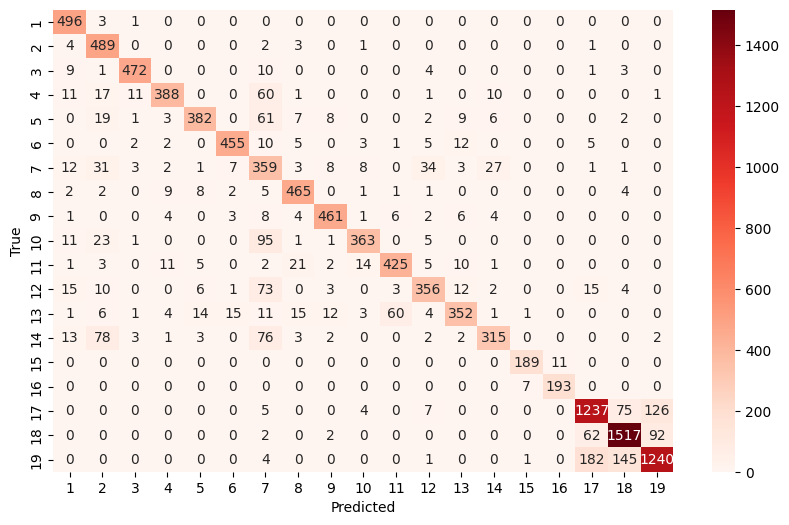

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(labels_list, predictions_list)

class_labels = [f'{i}' for i in range(1, 20)]

plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)

# 축 레이블 추가
plt.xlabel('Predicted')
plt.ylabel('True')

# 플롯 보여주기
plt.show()

In [107]:
print(len(labels_list))

12102


# TEMP

In [51]:
pred_str_list = [item for sublist in pred_str_list for item in sublist]

In [52]:
pred_str_list

['내',
 ' ',
 '몸',
 '에',
 ' ',
 '손',
 '대',
 '지',
 ' ',
 '마',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '세',
 '요',
 ' ',
 '다',
 '시',
 '�',
 '�',
 '�',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '내',
 ' ',
 '몸',
 '에',
 ' ',
 '손',
 '대',
 '지',
 ' ',
 '마',
 '�',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '내',
 ' ',
 '몸',
 '에',
 ' ',
 '손',
 '대',
 '지',
 ' ',
 '마',
 '어',
 '딜',
 ' ',
 '손',
 '대',
 '�',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '손',
 '대',
 '지',
 ' ',
 '마',
 '�',
 '�',
 '�',
 '�',
 '내',
 ' ',
 '몸',
 ' ',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '�',
 '�',
 '어',
 '딜',
 ' ',
 '손',
 '대',
 '어',
 '딜',
 ' ',
 '만',
 '져',
 '내',
 ' ',
 '몸',
 ' ',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '�',
 '�',
 '�',
 '내',
 ' ',
 '몸',
 '에',
 ' ',
 '손',
 '대',
 '지',
 ' ',
 '마',
 '�',
 '내',
 ' ',
 '몸',
 ' ',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '�',
 '�',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '�',
 '�',
 '�',
 '�',
 '내',
 ' ',
 '몸',
 '에',
 ' ',
 '손',
 '대',
 '지',
 ' ',
 '마',
 '만',
 '지',
 '지',
 ' ',
 '마',
 '세',
 '요',
 '�',
 '�',
 '�',
 '�',
 '내',
 ' ',
 '몸',
 '에',
 ' ',
 '손',
 '대',
 '지'

In [43]:
def print_colored_bar(a):
    for color_code in a:
        if color_code in [0]:
            print('\033[30m█', end='')  # 검은색 출력
        elif color_code in [15, 16, 17, 18, 19]:
            print('\033[34m█', end='')  # 파란색 출력
        else:
            print('\033[91m█', end='')  # 빨간색 출력
    print('\033[0m')  # 리셋하여 색깔 초기화

# 막대기 출력
for i in range(0, 1000, 20):
    a = list(logits_pred_list[i][0][::10])
    print('pred')
    print_colored_bar(a)
    a = list(logits_label_list[i][0][::10])
    print('label')
    print_colored_bar(a)

pred
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
label
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
pred
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
label
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
pred
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
label
██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
pred
████████████████████████████████████████████████████████

In [45]:
predictions_list = [tensor.item() for tensor in predictions_list]
labels_list = [tensor.item() for tensor in labels_list]

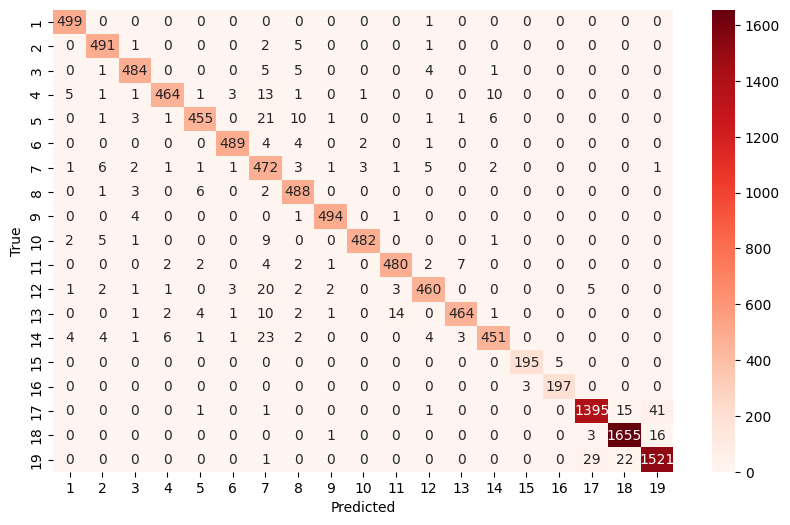

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(labels_list, predictions_list)

class_labels = [f'{i}' for i in range(1, 20)]

plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)

# 축 레이블 추가
plt.xlabel('Predicted')
plt.ylabel('True')

# 플롯 보여주기
plt.show()

# 5. Text Accuracy

In [62]:
import pandas as pd

df = pd.read_csv('text_counts.csv')

In [68]:
selected_texts = df[df['label'] <= 14]['text'].tolist()
selected_texts

['112 좀 불러줘',
 '112 좀 불러줘',
 '112에 신고에 주세요',
 '112에 신고해',
 '112에 신고해 주세요',
 '112에 전화해',
 '112에 전화해',
 '119 불러주세요',
 '119 좀 불러주세요',
 '119 좀 불러줘',
 '119 좀 불러줘',
 '119에 신고해',
 '119에 신고해',
 '119에 신고해 주세요',
 '119에 전화해',
 '119에 전화해',
 '가로수가 쓰러졌어요',
 '가스 고장이야',
 '가스 냄새 같아',
 '가스 냄새 나',
 '가스 냄새 아니야',
 '가스 냄새 인가',
 '가스 냄새가 나와',
 '가스 냄새가 나요',
 '가스 냄새나',
 '가스 냄새인가',
 '가스 새고 있는데',
 '가스 새나',
 '가스 새는 거 같아',
 '가스 샌다',
 '가스 샜다',
 '가스 터졌다',
 '가스 터졌다.',
 '가스 터진 거 같아',
 '가스 터진다',
 '가스 터진다.',
 '가스 환기 시켜',
 '가스 환기시켜',
 '가스가 새나',
 '가스가 샌다',
 '가스가 터졌어요',
 '가스가 폭발했어요',
 '가스다',
 '가슴 통증이 심해요',
 '가진 거 다 내놔',
 '가진 게 이것밖에 없어요',
 '간판이 떨어졌어요',
 '갇혔나 봐',
 '갇혔나 봐',
 '갇혔나봐.',
 '갇혔나봐.',
 '갇혔다',
 '갇혔어',
 '갇힌 거 같아',
 '갇힌 것 같아',
 '감전 조심해',
 '감전돼서 아파',
 '감전됐어',
 '감전되면 어떡해',
 '감전될 것 같아',
 '감전될까 봐 무서워',
 '갑자기 쓰러졌어요',
 '강아지 조심해',
 '강아지 피해',
 '강풍 부는 거 같아',
 '강풍 부는 것 같아',
 '강풍 부니까 나가지 마',
 '강풍 분다',
 '강풍 조심해',
 '강풍이네',
 '개 만지지 마',
 '개 사나워',
 '개 조심해',
 '거기 누구 없어요',
 '거기 누구 있어요',
 '거기 누구 있어요',
 '거긴 안 돼',
 '건물 바닥이 갈라졌어요',
 '건물바닥이 갈라

In [89]:
text_labels = [label < 14 for label in labels_list]
text_labels

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [88]:
text_preds = []
for pred in pred_str_list:
    flag = False
    for label in selected_texts:
        if label in pred:
            flag = True
    text_preds.append(flag)
text_preds

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [98]:
print(labels_list.index(14))
print(len(text_labels), len(text_preds))

3000
12102 11702


In [104]:
acc = 0
tp = 0
fp = 0
fn = 0
tn = 0
n = len(text_labels)
new_text_preds = text_preds[:3000] + [False]*400 + text_preds[3000:]
for i in range(n):
    label = text_labels[i]
    pred = new_text_preds[i]
    if label == pred:
        acc += 1/n
    if label == True and pred == True:
        tp += 1/n
    elif label == False and pred == True:
        fp += 1/n
    elif label == True and pred == False:
        fn += 1/n
    else:
        tn += 1/n
print(acc)
print(f"{tp:.5f} | {fp:.5f}")
print(f"{fn:.5f} | {tn:.5f}")

0.9620723847295398
0.54239 | 0.00190
0.03603 | 0.41968


In [92]:
print(len(text_labels), len(text_preds))

12102 11702


In [140]:
import librosa
y, s = librosa.load("비위급상황.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    input = {"input_features": input_features,
             "dec_input_ids": torch.tensor(tokenizer(['']).input_ids),
            }
    output = model(input)
    logits = output[1]
    prediction = torch.argmax(logits, dim=-1)
    mode, _ = torch.mode(prediction)
    print("prediction:", mode.item())

prediction: 18


In [141]:
y, s = librosa.load("위급상황.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    input = {"input_features": input_features,
             "dec_input_ids": torch.tensor(tokenizer(['']).input_ids),
            }
    output = model(input)
    logits = output[1]
    prediction = torch.argmax(logits, dim=-1)
    mode, _ = torch.mode(prediction)
    print("prediction:", mode.item())

prediction: 13


In [142]:
y, s = librosa.load("낙상.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    input = {"input_features": input_features,
             "dec_input_ids": torch.tensor(tokenizer(['']).input_ids),
            }
    output = model(input)
    logits = output[1]
    prediction = torch.argmax(logits, dim=-1)
    mode, _ = torch.mode(prediction)
    print("prediction:", mode.item())

prediction: 9


In [158]:
for label in selected_texts:
    if label in '악':
        print('yes')

In [155]:
y, s = librosa.load("실내.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    input = {"input_features": input_features,
             "dec_input_ids": torch.tensor(tokenizer(['']).input_ids),
            }
    output = model(input)
    logits = output[1]
    prediction = torch.argmax(logits, dim=-1)
    mode, _ = torch.mode(prediction)
    print("prediction:", mode.item())

prediction: 14


In [152]:
y, s = librosa.load("지연 위급상황.wav", sr=16000)

input_features = processor(y, sampling_rate=16000, return_tensors="pt").input_features
with torch.no_grad():
    input = {"input_features": input_features,
             "dec_input_ids": torch.tensor(tokenizer(['']).input_ids),
            }
    output = model(input)
    logits = output[1]
    prediction = torch.argmax(logits, dim=-1)
    mode, _ = torch.mode(prediction)
    print('prediction', mode)

prediction tensor([13], device='cuda:0')


# TEST

In [164]:
A = [label < 14 for label in labels_list]
B = [pred < 14 for pred in predictions_list]

In [165]:
acc = 0
for a, b in zip(A, B):
    if a == b:
        acc += 1 / len(A)
print(acc)

0.9985126425381442


In [166]:
import json

with open('pred_Whisper.json', 'w') as file:
    json.dump(B, file)

In [171]:
import json

json_file_path = "pred_CNN.json"

# JSON 파일 불러오기
with open(json_file_path, 'r') as file:
    data = json.load(file)

In [208]:
LABELS_LIST = A
WHISPER_ENCODER_LIST = B
CNN_LIST = data
WHISPER_DECODER_LIST = new_text_preds

In [209]:
acc = 0
n = len(LABELS_LIST)
for label, cnn, whisper_enc, whisper_dec in zip(LABELS_LIST, CNN_LIST,
                                                WHISPER_ENCODER_LIST,
                                                WHISPER_DECODER_LIST):
    pred = (sum([cnn, whisper_enc, whisper_dec]) >= 2)
    if label == pred:
        acc += 1 / n

print(f"Final Accuracy: {acc*100}%")

Final Accuracy: 99.93389522390196%
